At this point we've gathered all the athletes and matches necessary and stored them in a database.
In this file I will extract them, perform some preprocessing, and do some network analysis on them.


In [3]:
import numpy as np
import pandas as pd
import re
import sqlite3
import time
from pytictoc import TicToc
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network


In [4]:
# Read in athlete info
con = sqlite3.connect('bjj_network.db')
cur = con.cursor()
Athlete_Info = pd.read_sql_query('''SELECT * FROM Athlete_List''',con)
All_Matches = pd.read_sql_query('''SELECT * FROM Athlete_Matches''',con)


In [5]:
# Create Short Athlete_ID column
short_athlete_ID=pd.DataFrame(columns=['Short_Athlete_ID'],index=range(0,len(Athlete_Info['Athlete_ID'])))
for id in enumerate(Athlete_Info['Athlete_ID']):
    # print(id[0])
    short_athlete_ID.iloc[id[0],0] = id[1].split('-')[0]
Athlete_Info = Athlete_Info.join(short_athlete_ID)
Athlete_Info = Athlete_Info.drop(['level_0'],axis=1)
Athlete_Info = Athlete_Info.drop(['index'],axis=1)

In [6]:
Athlete_Info.head()

,Athlete_Name,Athlete_ID,Record,Birthdate,Short_Athlete_ID
0,"Aaron ""Tex"" Johnson",/people/6600946-aaron-tex-johnson,87-70-1,None,/people/6600946
1,Adam Wardzinski,/people/5950131-adam-wardzinski,180-52-2,None,/people/5950131
2,Alexssandro Sodre,/people/6749113-alexssandro-sodre,82-28-0,None,/people/6749113
3,Ana Carolina Vieira,/people/5950497-ana-carolina-vieira,47-12-0,November 19 1993,/people/5950497
4,Andre Galvao,/people/5951184-andre-galvao,165-31-2,September 29 1982,/people/5951184


In [7]:
# Get Rid of Extra Index Column
All_Matches = All_Matches.drop(['index'],axis=1)
# Create shortened versions of both athlete & Opponent ID so there are no names in the ID's
short_athlete_ID=pd.DataFrame(columns=['Short_Athlete_ID'],index=range(0,len(All_Matches['Athlete_ID'])))
for id in enumerate(All_Matches['Athlete_ID']):
    # print(id[0])
    short_athlete_ID.iloc[id[0],0] = id[1].split('-')[0]

short_opponent_ID=pd.DataFrame(columns=['Short_Opponent_ID'],index=range(0,len(All_Matches['Opponent_Link'])))
for id in enumerate(All_Matches['Opponent_Link']):
    # print(id[0])
    short_opponent_ID.iloc[id[0],0] = id[1].split('-')[0]
All_Matches = All_Matches.join(short_athlete_ID)
All_Matches = All_Matches.join(short_opponent_ID)

# Apparently some matches were recorded as an athlete fighting themselves so lets get rid of that
All_Matches = All_Matches[~All_Matches.apply(lambda x: x['Short_Athlete_ID'] == x['Short_Opponent_ID'], axis=1)]
# Drop Duplicates
All_Matches = All_Matches.drop_duplicates()
# Drop Unecessary Variables
All_Matches = All_Matches.drop(['Weight_Link'],axis=1)
All_Matches = All_Matches.drop(['Method_Link'],axis=1)
All_Matches = All_Matches.drop(['Event_Link'],axis=1)
All_Matches = All_Matches.drop(['Replay'],axis=1)
All_Matches = All_Matches.drop(['Replay_Link'], axis=1)
All_Matches = All_Matches.drop(['Date_Link'], axis=1)
All_Matches = All_Matches.drop(['W/L_Link'], axis = 1)

All_Matches.head()

,Athlete_ID,Year,Date,W/L,Method,Opponent,Opponent_Link,Weight,Event,Short_Athlete_ID,Short_Opponent_ID
0,/people/6600946-aaron-tex-johnson,2021,09/25,W,DQ,O. Sanchez,/people/6571306,Heavyweight,2021 FloGrappling WNO Championship,/people/6600946,/people/6571306
1,/people/6600946-aaron-tex-johnson,2021,09/25,L,Decision,T. Spriggs,/people/5950976,Heavyweight,2021 FloGrappling WNO Championship,/people/6600946,/people/5950976
2,/people/6600946-aaron-tex-johnson,2021,07/09,L,Decision,G. Batista,/people/5952220,Absolute Division,Fight to Win 176,/people/6600946,/people/5952220
3,/people/6600946-aaron-tex-johnson,2021,06/18,W,Decision,L. Barbosa,/people/5951235,---,Fight to Win 174,/people/6600946,/people/5951235
4,/people/6600946-aaron-tex-johnson,2021,05/15,W,Other,J. Hansen,/people/6749112,Ultra Heavyweight,2021 Pan IBJJF Jiu-Jitsu No-Gi Championship,/people/6600946,/people/6749112


In [8]:
# Add Name based on ID

All_Matches = All_Matches.merge(Athlete_Info[['Athlete_Name','Short_Athlete_ID']],left_on = 'Short_Athlete_ID',right_on='Short_Athlete_ID',how='left')
All_Matches.rename(columns={'Athlete_Name':'athlete_name'},inplace=True)

All_Matches = All_Matches.merge(Athlete_Info[['Athlete_Name','Short_Athlete_ID']],left_on = 'Short_Opponent_ID',right_on='Short_Athlete_ID',how='left')
All_Matches.rename(columns={'Athlete_Name':'Opponent_Name'},inplace=True)

All_Matches.rename(columns={'athlete_name':'Athlete_Name'},inplace=True)
All_Matches.rename(columns={'Short_Athlete_ID_x':'Short_Athlete_ID'},inplace=True)
All_Matches = All_Matches.drop(['Short_Athlete_ID_y'],axis=1)


All_Matches.head()

,Athlete_ID,Year,Date,W/L,Method,Opponent,Opponent_Link,Weight,Event,Short_Athlete_ID,Short_Opponent_ID,Athlete_Name,Opponent_Name
0,/people/6600946-aaron-tex-johnson,2021,09/25,W,DQ,O. Sanchez,/people/6571306,Heavyweight,2021 FloGrappling WNO Championship,/people/6600946,/people/6571306,"Aaron ""Tex"" Johnson",Orlando Sanchez
1,/people/6600946-aaron-tex-johnson,2021,09/25,L,Decision,T. Spriggs,/people/5950976,Heavyweight,2021 FloGrappling WNO Championship,/people/6600946,/people/5950976,"Aaron ""Tex"" Johnson",Tim Spriggs
2,/people/6600946-aaron-tex-johnson,2021,07/09,L,Decision,G. Batista,/people/5952220,Absolute Division,Fight to Win 176,/people/6600946,/people/5952220,"Aaron ""Tex"" Johnson",Gustavo Batista
3,/people/6600946-aaron-tex-johnson,2021,06/18,W,Decision,L. Barbosa,/people/5951235,---,Fight to Win 174,/people/6600946,/people/5951235,"Aaron ""Tex"" Johnson","Lucas ""Hulk"" Barbosa"
4,/people/6600946-aaron-tex-johnson,2021,05/15,W,Other,J. Hansen,/people/6749112,Ultra Heavyweight,2021 Pan IBJJF Jiu-Jitsu No-Gi Championship,/people/6600946,/people/6749112,"Aaron ""Tex"" Johnson",John Hansen


# Network time
First make a list of all athletes

In [9]:
Athletes = Athlete_Info.Athlete_Name.values.tolist()

Now we need to make a list of edges, this will be [('aaron johnson','orlando sanchez'),('aaron johnson','tim spriggs')]

Below will be an example

In [10]:
# Init graph
#G= nx.Graph() original graph without direction
G = nx.DiGraph()

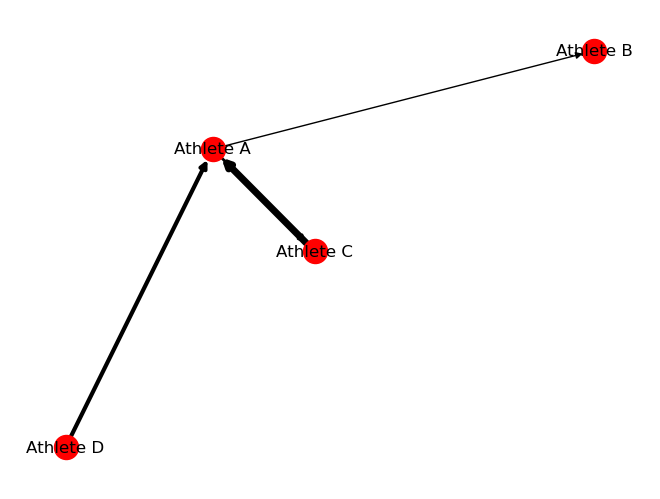

In [11]:
names = ['Athlete A','Athlete B','Athlete C','Athlete D']
# Ive added a few athletes but also reciprical edges, so say athletes a and c have faced each other 7 times
# but athlete c won 5 of them, how will that look?
edges = [('Athlete C','Athlete A',{'weight':5}),
         ('Athlete A','Athlete C',{'weight':2}), 
         ('Athlete D','Athlete A',{'weight':3}),
         ('Athlete A','Athlete B',{'weight':1})]

G.add_nodes_from(names)
G.add_edges_from(edges)
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G,width = weights, with_labels = True,node_color = 'red')

# Now on my data
I'll need to subset just the wins from my data.
Then get the athlete who won and the athlete who lost.
Group all their matches for weights.
Then figure out how to make it into the above format.


In [12]:
# Get only wins
Wins = All_Matches[All_Matches['W/L']=='W']
Wins.head()
Wins.shape

(22519, 13)

In [13]:
# Lets remove any rows where either athlete is missing.
Wins = Wins.dropna(subset = ['Athlete_Name','Opponent_Name'])
Wins.shape

(13276, 13)

In [14]:
Match_Pairs = Wins.groupby(['Athlete_Name','Opponent_Name'])['W/L'].count().reset_index()
Match_Pairs.head()

,Athlete_Name,Opponent_Name,W/L
0,AJ Agazarm,Alex Cabanes,1
1,AJ Agazarm,Alex Huddleston,1
2,AJ Agazarm,Andreas Perales,3
3,AJ Agazarm,Ary Farias,1
4,AJ Agazarm,Ashley Williams,1


In [25]:
Match_Pairs.isna().any()

Athlete_Name     False
Opponent_Name    False
W/L              False
dtype: bool

In [30]:
Match_Pairs.dtypes

Athlete_Name     object
Opponent_Name    object
W/L               int64
dtype: object

I wanted to confirm that the directionality was correct so I exported Match_Pairs to a csv file.
A perfect example are the three matchups between PJ Barch and Dante Leon, where Dante has won twice to PJ's once. 
In Match_Pairs this shows up correctly, where Dante Leon -> PJ Barch has a value of 2, and PJ Barch -> Dante Leon has a value of 1.

In [15]:
# Init Graph & add 1 node for each athlete
Graph = nx.DiGraph()
Graph.add_nodes_from(Athletes)


In [16]:
# Loop through each row in Match_Pairs to add edges
for row in range(0,len(Match_Pairs)):
    Athlete = Match_Pairs.iloc[row,0]
    Opponent = Match_Pairs.iloc[row,1]
    Weight = Match_Pairs.iloc[row,2]
    
    Graph.add_edge(Athlete, Opponent, weight = Weight)

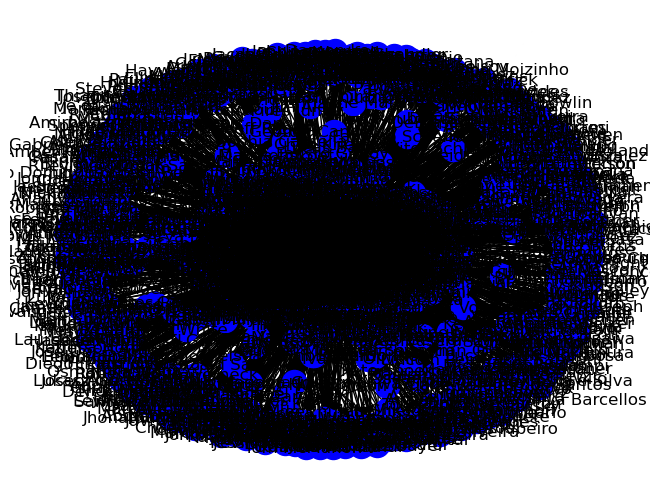

In [17]:
weights = [Graph[u][v]['weight'] for u, v in Graph.edges()]
nx.draw(Graph,width = weights, with_labels = True,node_color = 'blue')

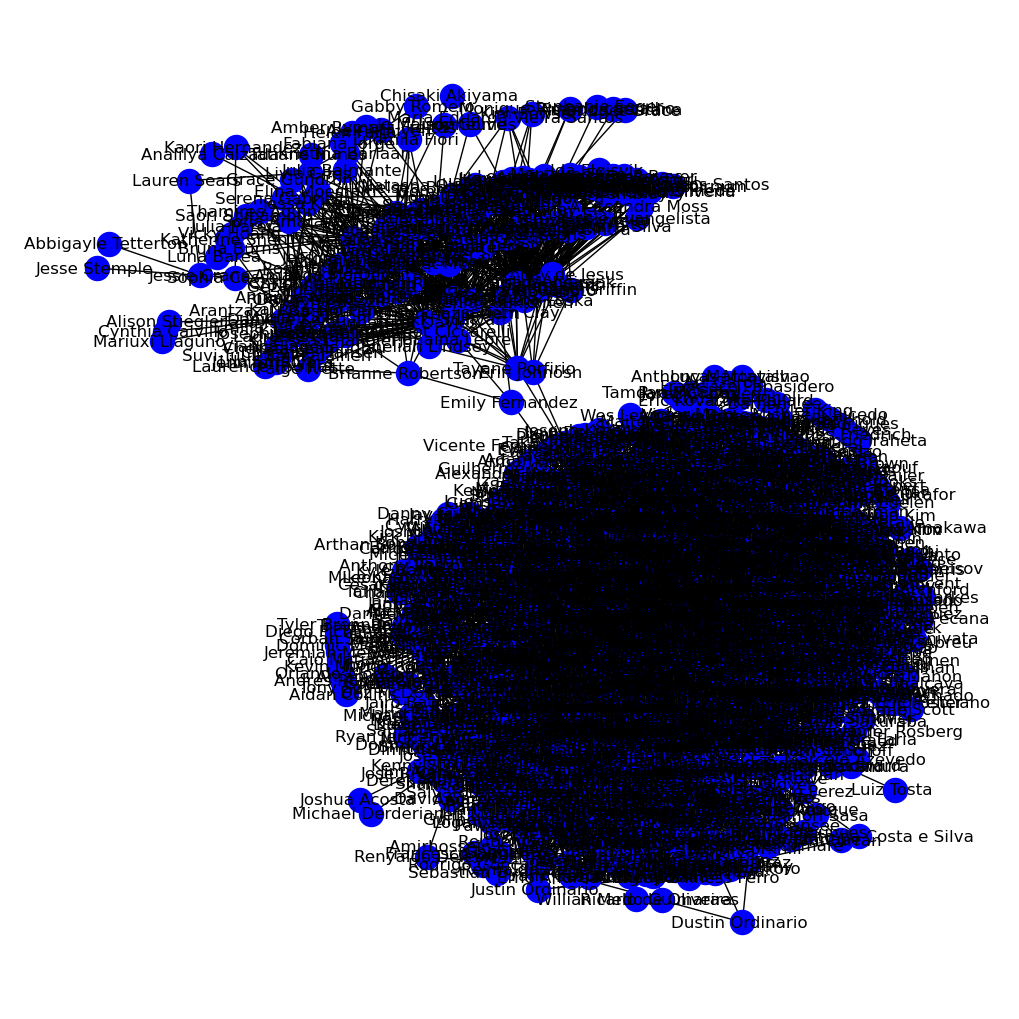

In [20]:
G = nx.from_pandas_edgelist(Match_Pairs,
                            source = 'Athlete_Name',
                            target = 'Opponent_Name',
                            edge_attr = 'W/L',
                            create_using = nx.Graph())
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize = (10,10))
nx.draw(G,with_labels = True, node_color = 'blue',edge_cmap = plt.cm.Blues, pos = pos)
plt.show()




In [34]:
# Failed pyvis attempt 
from IPython.display import display, HTML
net = Network(notebook=True, width= '1000px',height='700px',bgcolor='#222222',font_color='white',cdn_resources='in_line')
net.from_nx(G)
#net.show("bjj.html",local = True, notebook = True)
html = net.generate_html()
with open("example.html", mode='w', encoding='utf-8') as fp:
        fp.write(html)
display(HTML(html))

In [31]:
# Using the pyvis package
bjj_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white",notebook=True,cdn_resources='in_line')
bjj_net.barnes_hut()

sources = Match_Pairs['Athlete_Name']
targets = Match_Pairs['Opponent_Name']
weights = Match_Pairs['W/L']

edge_data = zip(sources, targets, weights)
for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]

                bjj_net.add_node(src, src, title=src)
                bjj_net.add_node(dst, dst, title=dst)
                bjj_net.add_edge(src, dst, value=w)

neighbor_map = bjj_net.get_adj_list()
# add neighbor data to node hover data
for node in bjj_net.nodes:
                node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
                node["value"] = len(neighbor_map[node["id"]])

bjj_net.show("bjj_graphic.html")


TypeError: show() got an unexpected keyword argument 'encoding'

In [ ]:
# 